# Style Transfer Training

## Import Library

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T 
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

# get utils functions
from utils import grammatrix, loss_of_style, loss_of_content, content_transform, detransform_content, rescale


## Get data from images

In [2]:
# The content is the image of the user. The style is the image of the style.
# content image is stored in images/omkar.jpeg and style image is stored in images/generosity.jpeg
content_image = PIL.Image.open("images/omkar.jpg")
style_image = PIL.Image.open("images/van_gogh.jpeg")
style_name = 'van_gogh'

## Get pretrained models of vgg16 and resnet18

In [3]:
# Load VGG16 model
# The VGG16 model is a pretrained CNN model that was trained on the ImageNet dataset.
vgg16 = torchvision.models.vgg16(pretrained=True).features

# Load ResNet18 model
resnet18 = torchvision.models.resnet18(pretrained=True)


In [4]:
vgg16[21]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [5]:
resnet18.layer2[1]

BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## train function for style transfer

In [5]:
# defining get_features function 
def get_features(image, model, model_name):
    '''
    Getting feature map from each layer of the model
    '''
    features = list()
    first_feature = image
    if model_name == 'vgg16':
        model = model.features
    # we add image as the input to the model
    for idx, layer in enumerate(model._modules.values()):
        image = layer(first_feature)
        features.append(image)
        first_feature = image
    return features 

In [25]:
def train_st(style, style_layer, style_weight, content, content_layer, content_weight, style_size, image_size, device, model, style_image_name, num_epochs):
    '''
    Train Style Transfer, based on Gatys' paper.
    :Input:
    - style: PyTorch tensor, style image
    - style_layer: int, index of style layer
    - style_weight: float, weight of style layer
    - content: PyTorch tensor, content image
    - content_layer: int, index of content layer
    - content_weight: float, weight of content layer
    - style_size: int, size of style image
    - image_size: int, size of image
    - device: PyTorch device
    - model: 'vgg16' or 'resnet18'
    - style_image_name: string, name of style image
    - num_epochs
    
    :Output:
    - image: PyTorch tensor, image
    '''
    # model 
    if model == 'vgg16':
        model_1 = torchvision.models.vgg16(pretrained=True).to(device)
    elif model == 'resnet18':
        model_1 = torchvision.models.resnet18(pretrained=True).to(device)

    # get style transform
    style = content_transform(style, style_size)
    # convert type of style to float
    style = style.type(torch.cuda.FloatTensor).to(device)

    # get content transform
    content = content_transform(content, image_size)
    # convert type to float
    content = content.type(torch.cuda.FloatTensor).to(device)

    # get style and content features
    content_features = get_features(content, model_1, model)
    style_features = get_features(style, model_1, model)

    # the layer on which we want the content to be 
    content_layer_output = content_features[content_layer]
    # the layers on which we want the style to be
    style_layers_output = [grammatrix(style_features[layer], True) for layer in style_layer]

    # First, initialize the image on which we want to perform style transfer with type torch.FloatTensor
    image = content.clone().type(torch.cuda.FloatTensor).requires_grad_(True).to(device)
    
    # Hyperparameters
    num_epochs = num_epochs
    learning_rate = 1
    decayed_learning_rate = 10

    # define the optimizer as Adam
    optimizer = torch.optim.Adam([image], lr=learning_rate)

    best_loss = float('inf')

    for epoch in range(num_epochs):
        if epoch < num_epochs-50:
            image.data.clamp_(-1.5, 1.5)
        # model train
        model_1.train()
        optimizer.zero_grad()

        # get the features of the image
        image_features = get_features(image, model_1, model)

        # get the content loss
        content_loss = loss_of_content(image_features[content_layer], content_weight, content_layer_output)

        # get the style loss
        style_loss = loss_of_style(image_features, style_layer, style_layers_output, style_weight)

        # get the total loss
        total_loss = content_loss + style_loss

        # perform backpropagation
        total_loss.backward(retain_graph=True)

        if epoch > num_epochs-40:
            optimizer = torch.optim.Adam([image], lr=learning_rate/10)

        # update the image
        optimizer.step()

        

        if epoch % 10 == 0:
            print("Epoch {}:".format(epoch))
            print("Content Loss: {:.4f}".format(content_loss.item()))
            print("Style Loss: {:.4f}".format(style_loss.item()))
            print("Total Loss: {:.4f}".format(total_loss.item()))
            print()

            # display the image
            plt.axis("off")
            plt.imshow(detransform_content(image.data.cpu(), image_size))
            plt.show()

            # save the checkpoint
            # if checkpoints folder doesn't exist, create it
            if not os.path.exists("checkpoints"):
                os.mkdir("checkpoints")
            # save the checkpoint of the model
            if total_loss.item() < best_loss:
                model_1.eval()
                best_loss = total_loss.item()
                torch.save(model_1.state_dict(), "checkpoints/{}_model_{}.pth".format(style_image_name, epoch))
                # save the image in pth format
                torch.save(image.data, "checkpoints/{}_image_{}.pth".format(style_image_name, epoch))
                print("Saved checkpoint of model and image")
        
        if best_loss > total_loss.item():
            # save the best model and image
            model_1.eval()
            best_loss = total_loss.item()
            torch.save(model_1.state_dict(), "checkpoints/{}_model_best.pth".format(style_image_name))
            torch.save(image.data, "checkpoints/{}_image_best.pth".format(style_image_name))

## Training

In [30]:
# parameters for train_st for vgg

parameters = dict(
    style = style_image,
    # get any layers of vgg model
    style_layer = (7, 10),
    style_weight = (500, 12),
    content = content_image,
    content_layer = 2,
    content_weight = 5e-3,
    style_size = 192,
    image_size = 512,
    device = device,
    model = 'vgg16',
    style_image_name = style_name,
    num_epochs = 1000
)



Epoch 0:
Content Loss: 0.0000
Style Loss: 161.5657
Total Loss: 161.5657



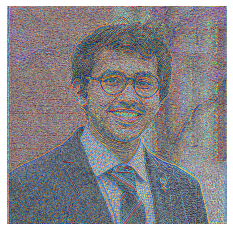

Saved checkpoint of model and image
Epoch 10:
Content Loss: 234565.6719
Style Loss: 8779.1709
Total Loss: 243344.8438



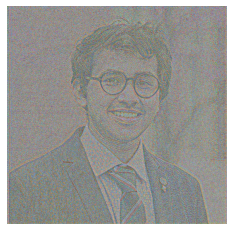

Epoch 20:
Content Loss: 59772.2969
Style Loss: 1046.1310
Total Loss: 60818.4297



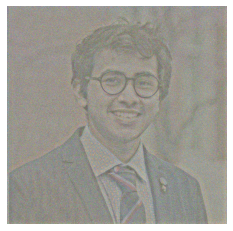

Epoch 30:
Content Loss: 27321.2930
Style Loss: 250.8718
Total Loss: 27572.1641



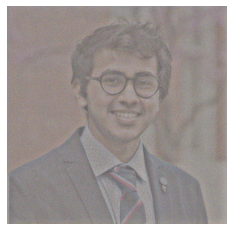

Epoch 40:
Content Loss: 11984.7764
Style Loss: 94.9303
Total Loss: 12079.7070



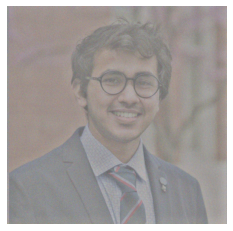

Epoch 50:
Content Loss: 5358.9541
Style Loss: 95.8034
Total Loss: 5454.7573



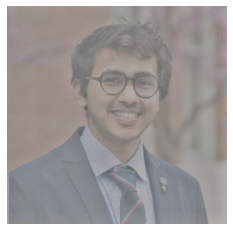

Epoch 60:
Content Loss: 2505.3289
Style Loss: 116.8766
Total Loss: 2622.2056



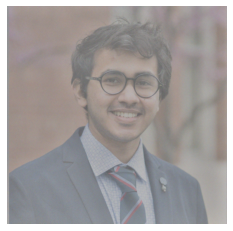

Epoch 70:
Content Loss: 1217.1862
Style Loss: 133.6668
Total Loss: 1350.8530



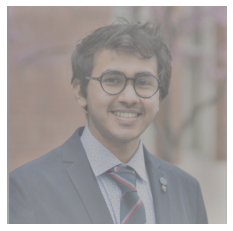

Epoch 80:
Content Loss: 606.0706
Style Loss: 144.9371
Total Loss: 751.0076



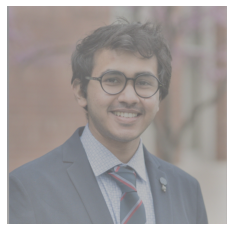

Epoch 90:
Content Loss: 318.5531
Style Loss: 151.4989
Total Loss: 470.0520



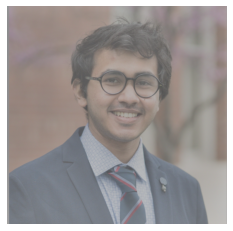

Epoch 100:
Content Loss: 187.4150
Style Loss: 154.7720
Total Loss: 342.1870



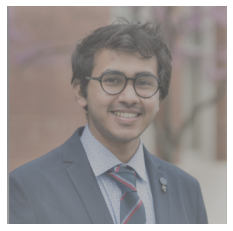

Epoch 110:
Content Loss: 127.8819
Style Loss: 156.1418
Total Loss: 284.0236



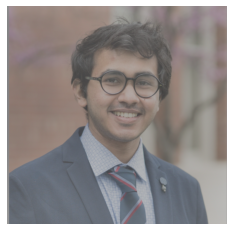

Epoch 120:
Content Loss: 103.1228
Style Loss: 156.6673
Total Loss: 259.7901



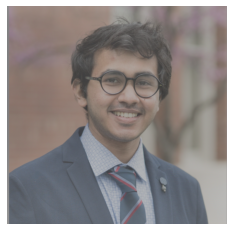

KeyboardInterrupt: ignored

In [31]:
train_st(**parameters)